# Comparative study of various models with speech emotion recognition 

In [1]:
#Required libraries
import librosa
import librosa.display
import soundfile, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import glob # the glob module is used to retrieve files/pathnames matching a specified pattern
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import random
from sklearn import preprocessing
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from random import randint
#import pylab

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Scale the data
from sklearn.preprocessing import StandardScaler
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier


## RAVDESS

Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):<br>
Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440.<br>
Eight emotions were selected for speech that is angry, calm, disgust, fearful, happy, neutral, sad and surprise.<br>
Citation: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391

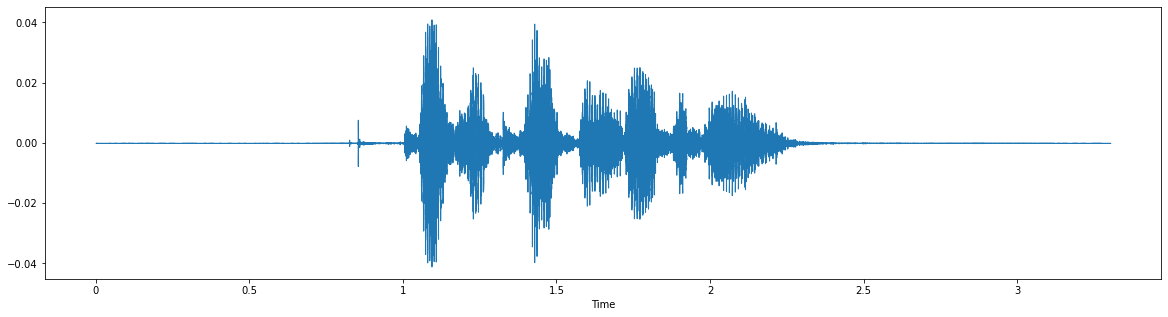

In [7]:
# Loading one recording and playing it
eg = 'C:/Users/annam/OneDrive/Desktop/PG Data_science/Assignments/Dissertation/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'
x, sampling_rate = librosa.load(eg)
plt.figure(figsize=(20, 5))
librosa.display.waveshow(x, sr=sampling_rate)
plt.show()
#To play the recording
ipd.Audio(eg) 

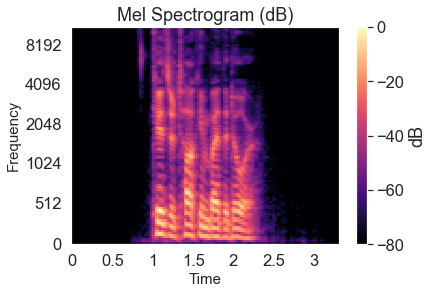

In [49]:
#Mel spectrogram of the above audio
S = librosa.feature.melspectrogram(y=x, sr=sampling_rate)
specc=librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(specc,x_axis='time', y_axis='mel', cmap='magma')
plt.title('Mel Spectrogram (dB)', fontdict=dict(size=18))
plt.colorbar(label='dB')
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()
pylab.close()

'According to the information provided on the website of Ravdess, each filename is unique. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:
Filename identifiers <br>
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).<br>
Vocal channel (01 = speech, 02 = song).<br>
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).<br>
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.<br>
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").<br>
Repetition (01 = 1st repetition, 02 = 2nd repetition).<br>
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).'<br>
Here we are defining a dictionery to hold all the 8 emotions.

In [4]:
file_location = 'C:/Users/annam/OneDrive/Desktop/PG Data_science/Assignments/Dissertation/Audio_Speech_Actors_01-24/*'
#All type of emotions present in the dataset
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}
# Emotions that are required to be observed
observed_emotions=['neutral','calm','happy','sad','angry','fearful', 'disgust','surprised']

In [5]:
#Function for extracting features : mfcc, mel spectrogram and chroma are the features that will be extracted from the audio.
#Using the Librosa library we are able to access these features.
def audio_features(file_name, mfcc, chroma):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type = 'kaiser_fast')
    stft = np.abs(librosa.stft(X))
    result = np.array([])
    #Mfcc
    mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 40).T, axis = 0)
    result = np.hstack((result, mfccs))
    #chroma
    chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sample_rate).T,axis = 0)
    result = np.hstack((result, chroma))
    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y = X, sr = sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

In [6]:
#This function splits the dataset into training and test set
def test_train_split(X,y) :
    X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2)
    return X_train,X_test,Y_train,Y_test

In [7]:
#Genetic algorithm is implemented in various functions.
#To initialize a population randomly
def initialization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype = np.bool)     
        chromosome[:int(0.3*n_feat)] = False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

#Returns the parents along with the scores
def fitness_score(population):
    scores = []
    for chromosome in population:
        final_model.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = final_model.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

#Selection the parents for the next generation
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

#Chooses half of the first and second parent
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

#The crossover population is randomly flipped
def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

#Executes the entire algorithm for a mentioned number of generations
def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    selected_feature = []
    best_score = []
    population_nextgen = initialization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1]) 
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        selected_feature.append(pop_after_fit[0])
        best_score.append(scores[0])
    return selected_feature,best_score

A crucial step in studying and discovering relationships between various things is feature extraction. We need to transform the audio data presented into a format that the models can interpret because, as we already know, they cannot do it directly.

In [8]:
#Extraction of features from the audio
x,y=[],[]
for actor in glob.glob(file_location):
    for name in glob.glob(actor +'/*'):
        file_name=os.path.basename(name)
        #Emotion is assigned according to the numbers
        emotion=emotions[name[-18:-16]]
        #Gender of the actor is assigned
        if int(name[-6:-4])%2==0:
            emotion = emotion + '_female'
        else :
            emotion = emotion + '_male'
        feature = audio_features(name, mfcc=True, chroma=True)
        x.append(feature)
        y.append(emotion)

In [9]:
#Converting the inputs and targets into dataframe type
X = pd.DataFrame(x)
Y = pd.DataFrame(y)

In [10]:
#Viewing both the dataset
X.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,-700.398926,58.630211,-3.025852,16.040241,4.248529,3.869935,-6.381716,-0.188635,-13.735003,-0.319724,...,0.000002,0.000002,0.000001,6.755615e-07,3.586785e-07,3.909839e-07,2.609651e-07,6.226124e-08,1.362779e-08,1.109996e-09
1,-695.557861,59.240154,-5.372777,19.776365,5.200387,3.324630,-4.668406,-2.193975,-14.508076,1.307903,...,0.000005,0.000004,0.000003,1.987250e-06,1.190612e-06,9.930161e-07,3.063795e-07,9.424937e-08,1.618848e-08,1.342518e-09
2,-694.004639,61.495857,-3.263948,16.969225,2.139788,4.262372,-5.021102,-2.624759,-12.893682,-1.310918,...,0.000007,0.000007,0.000006,4.424522e-06,3.508267e-06,2.257955e-06,1.501948e-06,3.045085e-07,4.976776e-08,5.271561e-09
3,-687.560242,59.405357,-0.694622,16.651770,3.698781,6.139021,-4.583301,-4.142577,-12.971965,-0.855624,...,0.000011,0.000012,0.000008,7.291854e-06,1.427418e-05,3.806916e-06,1.224669e-06,3.749388e-07,6.362352e-08,5.403002e-09
4,-729.994568,66.495644,-0.961856,19.051710,4.278643,5.617668,-6.769211,-0.485452,-12.788596,-2.069826,...,0.000004,0.000003,0.000002,3.176521e-06,1.137457e-06,2.980924e-07,1.331661e-07,4.653141e-08,8.594113e-09,7.509023e-10


In [11]:
Y.head()

,0
0,neutral_male
1,neutral_male
2,neutral_male
3,neutral_male
4,calm_male


In [12]:
X.shape

(1440, 180)

We can see that emotions are labelled and classified based on the gender. There are 180 features for each audio and also 1440 audios in total.

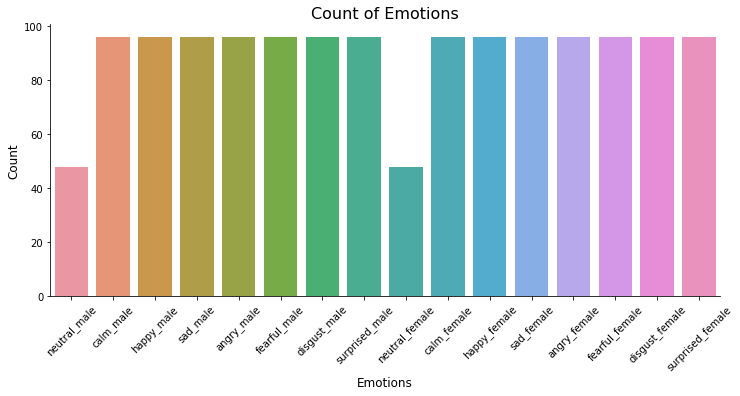

In [13]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(Y[0])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We have decided to use Logistic regression, Decision tree, Random forest classifier, K-Neighbours classifier and the MLP classifier.
To choose the best parameters and the best models we have used pipeline and grid search cv library.

In [14]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('SVM', svm.SVC(random_state=42))])
pipe_mlp = Pipeline([('MLP', MLPClassifier())])

In [15]:
#Various parameter to be selected are mentioned below
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range[1:],
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]
mlp_param_grid = [{'MLP__solver': ['adam'],
                   'MLP__learning_rate_init': [0.0001],
                   'MLP__max_iter': [300,500],
                   'MLP__hidden_layer_sizes': [500, 400, 300, 200, 100],
                   'MLP__activation': ['logistic','relu'],
                   'MLP__alpha': [0.0001, 0.001, 0.01],
                   'MLP__learning_rate' : ['adaptive']}]

In [16]:
# GridSearchCV helps in selecting good parameters for all the models.
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=3)
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=3)
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=3)
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=3)
svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=3)
mlp_grid_search = GridSearchCV(estimator=pipe_mlp,
        param_grid=mlp_param_grid,
        scoring='accuracy',
        cv=3)

In [17]:
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, mlp_grid_search]
X_train,X_test,Y_train,Y_test = test_train_split(X,Y)
for pipe in grids:
    pipe.fit(X_train,Y_train)

In [18]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'MLP Classifier'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test,Y_test)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
    print('____________________________________________')

Logistic Regression Test Accuracy: 0.5520833333333334
Logistic Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
____________________________________________
Decision Trees Test Accuracy: 0.3090277777777778
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 6, 'DT__min_samples_split': 2}
____________________________________________
Random Forest Test Accuracy: 0.4583333333333333
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 2}
____________________________________________
K-Nearest Neighbors Test Accuracy: 0.65625
K-Nearest Neighbors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 2, 'KNN__weights': 'distance'}
____________________________________________
Support Vector Machines Test Accuracy: 0.5868055555555556
Support Vector Machines Best Params: {'SVM__C': 6, 'SVM__kernel': 'rbf'}
____________________________________________
MLP Class

Model which has the greatest accuracy is considered to be the final_model, this is used as the fitness criteria for the genetic algortihm.

In [21]:
final_model = KNeighborsClassifier(metric= 'manhattan', n_neighbors=2, weights = 'distance')

In [22]:
final_model.fit(X_train, Y_train)
prediction = final_model.predict(X_test)
print(classification_report(Y_test, prediction))

                  precision    recall  f1-score   support

    angry_female       0.86      0.63      0.73        19
      angry_male       0.79      0.70      0.75        27
     calm_female       1.00      0.86      0.93        22
       calm_male       0.68      0.81      0.74        16
  disgust_female       0.67      0.64      0.65        22
    disgust_male       0.68      0.71      0.70        21
  fearful_female       0.58      0.78      0.67        18
    fearful_male       0.65      0.52      0.58        21
    happy_female       0.73      0.70      0.72        27
      happy_male       0.62      0.50      0.55        16
  neutral_female       0.50      0.71      0.59         7
    neutral_male       0.33      1.00      0.50         4
      sad_female       0.80      0.47      0.59        17
        sad_male       0.80      0.73      0.76        22
surprised_female       0.40      0.71      0.51        14
  surprised_male       0.67      0.53      0.59        15

        accu

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

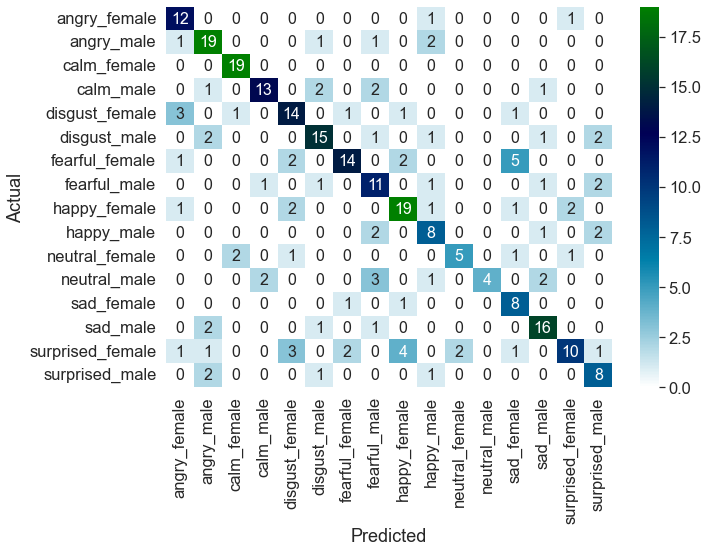

In [28]:
#Confusion matrix
cm = confusion_matrix(prediction, Y_test)
df_cm = pd.DataFrame(cm, columns= np.unique(prediction), index = np.unique(Y_test) )
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap="ocean_r", annot=True,annot_kws={"size": 16})

In [24]:
selected_features,best_scores = generations(X,y,size = 80, n_feat = X.shape[1], n_parents = 64, mutation_rate = 0.02, n_gen = 25,
                                      X_train = X_train, X_test = X_test, Y_train = Y_train, Y_test = Y_test)

Best score in generation 1 : [0.7326388888888888]
Best score in generation 2 : [0.7326388888888888]
Best score in generation 3 : [0.7534722222222222]
Best score in generation 4 : [0.7465277777777778]
Best score in generation 5 : [0.7395833333333334]
Best score in generation 6 : [0.7395833333333334]
Best score in generation 7 : [0.7326388888888888]
Best score in generation 8 : [0.7395833333333334]
Best score in generation 9 : [0.7395833333333334]
Best score in generation 10 : [0.75]
Best score in generation 11 : [0.7465277777777778]
Best score in generation 12 : [0.7465277777777778]
Best score in generation 13 : [0.75]
Best score in generation 14 : [0.7708333333333334]
Best score in generation 15 : [0.78125]
Best score in generation 16 : [0.7777777777777778]
Best score in generation 17 : [0.7777777777777778]
Best score in generation 18 : [0.7777777777777778]
Best score in generation 19 : [0.7777777777777778]
Best score in generation 20 : [0.7777777777777778]
Best score in generation 21 

After running 25 generations we can see that maximum accuracy obtained in the generation 16 with an accuracy of 77.8%.

In [25]:
feature_count = selected_features[15]
cnt = 0
f = []
for i in feature_count :   
    if i == True:
        f.append(cnt)
    cnt +=1
len(f)

108

108 features are selected from 180 by using genetic algorithm

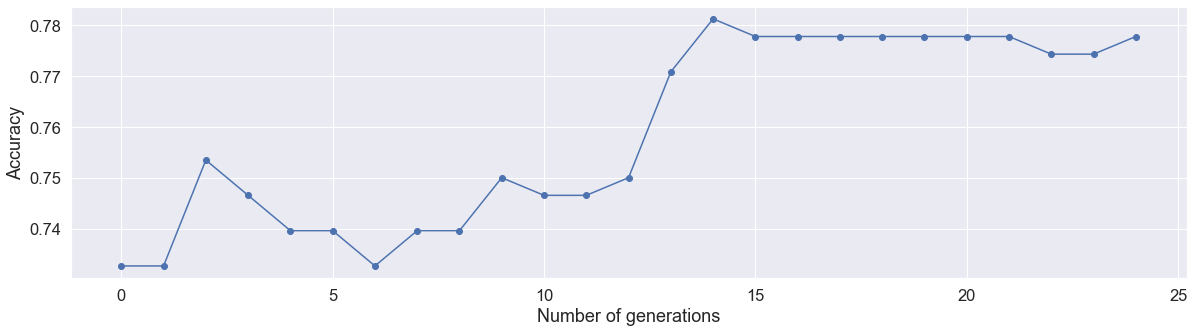

In [58]:
plt.figure(figsize=(20, 5))
plt.plot(best_scores,marker='o')
plt.xticks(range(0,len(best_scores), 1))
plt.ylabel('Accuracy')
plt.xlabel('Number of generations')
plt.show()